In [ ]:
!pip install contractions
!pip install nltk
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install gensim
!pip install scikit-learn
!pip install wordcloud

In [ ]:
import os
import glob
import re

import contractions
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
import seaborn as sns
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from wordcloud import WordCloud, STOPWORDS


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Exploratory Data Analysis

### Reading in the positive and negative reviews


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pos.csv to pos (3).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving neg.csv to neg (2).csv


In [ ]:
pos_file_path = 'data/pos/*.txt'  # Adjust this path to your specific directory
neg_file_path = 'data/neg/*.txt'

def get_data(file_path):
    files = glob.glob(file_path)
    df = pd.DataFrame(columns=['FileName', 'Content'])
    for file in files:
        # Extracting file name
        file_name = os.path.basename(file)
        # Reading file content
        with open(file, 'r', encoding='utf-8') as file_open:
            content = file_open.read()
        # Replaced 'df = df.append({'FileName': file_name, 'Content': content}, ignore_index=True)' in the following line
        file_to_add = pd.DataFrame({'FileName': [file_name], 'Content': [content]})
        df = pd.concat([df, file_to_add], ignore_index=True)
    return df

In [ ]:
pos_unclean_df = get_data(pos_file_path)
neg_unclean_df = get_data(neg_file_path)

In [ ]:
pos_unclean_df.head()

,FileName,Content


In [ ]:
neg_unclean_df.head()

,FileName,Content


### Generate rating from the txt file name

In [ ]:
def extract_rating_from_filename(filename):
    parts = filename.split("_")
    rating = parts[1].split(".")[0]
    return int(rating)

In [ ]:
pos_unclean_df['rating'] = pos_unclean_df['FileName'].apply(lambda z: extract_rating_from_filename(z))
pos_unclean_df.head()

,FileName,Content,rating


In [ ]:
#Check unique ratings
pos_ratings = pos_unclean_df['rating'].unique()
print(pos_ratings)

[]


In [ ]:
neg_unclean_df['rating'] = neg_unclean_df['FileName'].apply(lambda z: extract_rating_from_filename(z))
neg_unclean_df.head()

,FileName,Content,rating


In [ ]:
neg_ratings = neg_unclean_df['rating'].unique()
print(neg_ratings)

[]


In [ ]:
pos_unclean_df.head()

,FileName,Content,rating


In [ ]:
neg_unclean_df.head()

,FileName,Content,rating


### Cleaning Positive dataset


In [ ]:
#Only uncomment when need to generate csv, but dont need already
# pos_unclean_df.to_csv("pos.csv")
# neg_unclean_df.to_csv("neg.csv")

In [ ]:
# specify this to your directory. if using collab, just "pos.csv"
file_path = "pos.csv"
pos_unclean_df = pd.read_csv(file_path)
pos_unclean_df.drop(pos_unclean_df.columns[0], axis=1, inplace=True)
pos_unclean_df.head()

,FileName,Content,rating
0,10000_8.txt,Barman directed Any Way the Wind Blows as he w...,8
1,10001_7.txt,I really liked Tom Barman's AWTWB. You just ha...,7
2,10002_8.txt,Barman just wanted to make a movie because he ...,8
3,10003_10.txt,"This Belgian film, directed by Tom Barman, sin...",10
4,10004_9.txt,Any Way the Wind Blows is Tom Barmans (who is ...,9


In [ ]:
pos_unclean_df['rating'].value_counts()

10    9731
8     5859
7     4803
9     4607
Name: rating, dtype: int64

In [ ]:
pos_unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  25000 non-null  object
 1   Content   25000 non-null  object
 2   rating    25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [ ]:
pos_unclean_df.describe()

,rating
count,25000.00000
mean,8.77064
std,1.15738
min,7.00000
25%,8.00000
50%,9.00000
75%,10.00000
max,10.00000


In [ ]:
before =  pos_unclean_df.shape[0]
pos_unclean_df.drop_duplicates(inplace=True)
after = pos_unclean_df.shape[0]

print("No. of rows removed :", before - after)

No. of rows removed : 0


Remove HTML syntaxes

In [ ]:
HTML_TAG_PATTERN = re.compile(r'<[^>]+>', re.IGNORECASE)

def remove_html(data):
    # Remove HTML tags
    data = HTML_TAG_PATTERN.sub('', data)
    return data

In [ ]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_html(z))


In [ ]:
pos_unclean_df.head(10)

,FileName,Content,rating,Cleaned_Content
0,10000_8.txt,Barman directed Any Way the Wind Blows as he w...,8,Barman directed Any Way the Wind Blows as he w...
1,10001_7.txt,I really liked Tom Barman's AWTWB. You just ha...,7,I really liked Tom Barman's AWTWB. You just ha...
2,10002_8.txt,Barman just wanted to make a movie because he ...,8,Barman just wanted to make a movie because he ...
3,10003_10.txt,"This Belgian film, directed by Tom Barman, sin...",10,"This Belgian film, directed by Tom Barman, sin..."
4,10004_9.txt,Any Way the Wind Blows is Tom Barmans (who is ...,9,Any Way the Wind Blows is Tom Barmans (who is ...
5,10005_9.txt,"""Written on the Wind"" is an irresistible, wond...",9,"""Written on the Wind"" is an irresistible, wond..."
6,10006_10.txt,I'm not sure if this is some kind of masterpie...,10,I'm not sure if this is some kind of masterpie...
7,10007_9.txt,"WRITTEN ON THE WIND, directed by Douglas Sirk ...",9,"WRITTEN ON THE WIND, directed by Douglas Sirk ..."
8,10008_7.txt,An overblown melodrama typical of its period (...,7,An overblown melodrama typical of its period (...
9,10009_10.txt,"On the surface, ""Written on the Wind"" is a lur...",10,"On the surface, ""Written on the Wind"" is a lur..."


Remove URL Data

In [ ]:
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

In [ ]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_url(z))


Remove Emojis

In [ ]:
def remove_emoji(data):
    # Extended emoji range to include more characters, including newer ones and skin tone modifiers
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # additional symbols
                               u"\U000024C2-\U0001F251"  # additional symbols
                               u"\U0001F900-\U0001F9FF"  # supplementary symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # chess symbols, extended pictographs
                               u"\U0001FA70-\U0001FAFF"  # more extended pictographs
                               u"\U00002600-\U000026FF"  # miscellaneous symbols
                               u"\U00002700-\U000027BF"  # dingbats
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U000E0020-\U000E007F"  # Tag characters for emoji
                               "]+", flags=re.UNICODE)
    data = emoji_pattern.sub(r'', data)
    return data

In [ ]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: remove_emoji(z))

Lower Case text

In [ ]:
def lowercase(text):
  word_list = str(text).split(' ')
  return ' '.join([word.lower() for word in word_list])

In [ ]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Content'].apply(lambda z: lowercase(z))

In [ ]:
pos_unclean_df.head()

,FileName,Content,rating,Cleaned_Content
0,10000_8.txt,Barman directed Any Way the Wind Blows as he w...,8,barman directed any way the wind blows as he w...
1,10001_7.txt,I really liked Tom Barman's AWTWB. You just ha...,7,i really liked tom barman's awtwb. you just ha...
2,10002_8.txt,Barman just wanted to make a movie because he ...,8,barman just wanted to make a movie because he ...
3,10003_10.txt,"This Belgian film, directed by Tom Barman, sin...",10,"this belgian film, directed by tom barman, sin..."
4,10004_9.txt,Any Way the Wind Blows is Tom Barmans (who is ...,9,any way the wind blows is tom barmans (who is ...


Remove Contractions

In [ ]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Cleaned_Content'].apply(contractions.fix)

In [ ]:
pos_unclean_df.head()

,FileName,Content,rating,Cleaned_Content
0,10000_8.txt,Barman directed Any Way the Wind Blows as he w...,8,barman directed any way the wind blows as he w...
1,10001_7.txt,I really liked Tom Barman's AWTWB. You just ha...,7,i really liked tom barman's awtwb. you just ha...
2,10002_8.txt,Barman just wanted to make a movie because he ...,8,barman just wanted to make a movie because he ...
3,10003_10.txt,"This Belgian film, directed by Tom Barman, sin...",10,"this belgian film, directed by tom barman, sin..."
4,10004_9.txt,Any Way the Wind Blows is Tom Barmans (who is ...,9,any way the wind blows is tom barmans (who is ...


Remove punctuations

In [ ]:
def remove_punctuation(text):
    punctuation_pattern = re.compile(r'[^\w\s]')

    clean_text = punctuation_pattern.sub('', text)
    return clean_text

In [ ]:
pos_unclean_df['Cleaned_Content'] = pos_unclean_df['Cleaned_Content'].apply(lambda z: remove_punctuation(z))

In [ ]:
pos_unclean_df.head(30)

,FileName,Content,rating,Cleaned_Content
0,10000_8.txt,Barman directed Any Way the Wind Blows as he w...,8,barman directed any way the wind blows as he w...
1,10001_7.txt,I really liked Tom Barman's AWTWB. You just ha...,7,i really liked tom barmans awtwb you just have...
2,10002_8.txt,Barman just wanted to make a movie because he ...,8,barman just wanted to make a movie because he ...
3,10003_10.txt,"This Belgian film, directed by Tom Barman, sin...",10,this belgian film directed by tom barman singe...
4,10004_9.txt,Any Way the Wind Blows is Tom Barmans (who is ...,9,any way the wind blows is tom barmans who is a...
5,10005_9.txt,"""Written on the Wind"" is an irresistible, wond...",9,written on the wind is an irresistible wonderf...
6,10006_10.txt,I'm not sure if this is some kind of masterpie...,10,i am not sure if this is some kind of masterpi...
7,10007_9.txt,"WRITTEN ON THE WIND, directed by Douglas Sirk ...",9,written on the wind directed by douglas sirk a...
8,10008_7.txt,An overblown melodrama typical of its period (...,7,an overblown melodrama typical of its period m...
9,10009_10.txt,"On the surface, ""Written on the Wind"" is a lur...",10,on the surface written on the wind is a lurid ...


Data has been cleaned, now make a copy of it in pos_cleaned_df

In [ ]:
pos_cleaned_df = pos_unclean_df

Tokenization

In [ ]:
tokenizer = TweetTokenizer()
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(tokenizer.tokenize)

Remove Stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
#Come up with a set of words that we find are useful in determining sentiment from the stopwords
#keep_in_tokens = [Insert list of words to keep here]

def filter_tokens(tokens):
    return [token for token in tokens if token not in stop_words]

In [ ]:
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(filter_tokens)

Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

In [ ]:
pos_cleaned_df['Cleaned_Content'] = pos_cleaned_df['Cleaned_Content'].apply(lemmatize_tokens)

In [ ]:
pos_cleaned_df.head(10)

,FileName,Content,rating,Cleaned_Content
0,10000_8.txt,Barman directed Any Way the Wind Blows as he w...,8,barman directed way wind blow would sing deus ...
1,10001_7.txt,I really liked Tom Barman's AWTWB. You just ha...,7,really liked tom barman awtwb let come enjoy l...
2,10002_8.txt,Barman just wanted to make a movie because he ...,8,barman wanted make movie wanted simple succeed...
3,10003_10.txt,"This Belgian film, directed by Tom Barman, sin...",10,belgian film directed tom barman singer wellkn...
4,10004_9.txt,Any Way the Wind Blows is Tom Barmans (who is ...,9,way wind blow tom barman also know front man r...
5,10005_9.txt,"""Written on the Wind"" is an irresistible, wond...",9,written wind irresistible wonderfully kinky fi...
6,10006_10.txt,I'm not sure if this is some kind of masterpie...,10,sure kind masterpiece sleazy fluff elevated pe...
7,10007_9.txt,"WRITTEN ON THE WIND, directed by Douglas Sirk ...",9,written wind directed douglas sirk released 19...
8,10008_7.txt,An overblown melodrama typical of its period (...,7,overblown melodrama typical period mid 1950s a...
9,10009_10.txt,"On the surface, ""Written on the Wind"" is a lur...",10,surface written wind lurid glossy soap opera s...


In [ ]:
temp_df = pos_cleaned_df[['Cleaned_Content', 'rating']].copy()
temp_df.rename(columns = {'Cleaned_Content': 'Text', 'rating': "Sentiment"}, inplace=True)
temp_df.head()

,Text,Sentiment
0,barman directed way wind blow would sing deus ...,8
1,really liked tom barman awtwb let come enjoy l...,7
2,barman wanted make movie wanted simple succeed...,8
3,belgian film directed tom barman singer wellkn...,10
4,way wind blow tom barman also know front man r...,9


Generate the word cloud to visualise frequency of words

In [ ]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

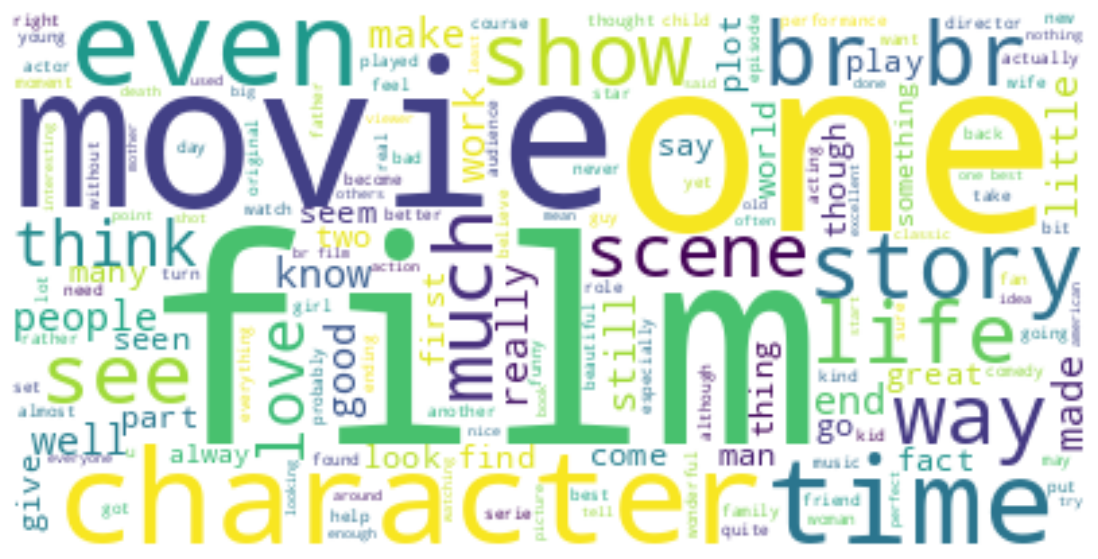

In [ ]:
pos = temp_df.Text
pos_text = " ".join(review for review in pos.astype(str))

pos_wcloud=generate_wcloud(pos_text)

### Cleaning Negative dataset

In [ ]:
#specify this to your directory. if using collab, just "pos.csv"
file_path = "neg.csv"
neg_unclean_df = pd.read_csv(file_path)
neg_unclean_df.drop(neg_unclean_df.columns[0], axis=1, inplace=True)
neg_unclean_df.head()

,FileName,Content,rating
0,10000_1.txt,This movie was the worst movie ever made on th...,1
1,10001_4.txt,"First, the CGI in this movie was horrible. I w...",4
2,10002_3.txt,The film is about a sabretooth on the lose at ...,3
3,10003_1.txt,Everything about this film is hog wash. Pitifu...,1
4,10004_2.txt,Spoilers will be in this. The movie could have...,2


In [ ]:
neg_unclean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  25000 non-null  object
 1   Content   25000 non-null  object
 2   rating    25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [ ]:
neg_unclean_df.describe()

,rating
count,25000.000000
mean,2.220040
std,1.186558
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [ ]:
before =  neg_unclean_df.shape[0]
neg_unclean_df.drop_duplicates(inplace=True)
after = neg_unclean_df.shape[0]

print("No. of rows removed :", before - after)

No. of rows removed : 0


In [ ]:
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: remove_html(z))

In [ ]:
neg_unclean_df.head(10)

,FileName,Content,rating,Cleaned_Content
0,10000_1.txt,This movie was the worst movie ever made on th...,1,This movie was the worst movie ever made on th...
1,10001_4.txt,"First, the CGI in this movie was horrible. I w...",4,"First, the CGI in this movie was horrible. I w..."
2,10002_3.txt,The film is about a sabretooth on the lose at ...,3,The film is about a sabretooth on the lose at ...
3,10003_1.txt,Everything about this film is hog wash. Pitifu...,1,Everything about this film is hog wash. Pitifu...
4,10004_2.txt,Spoilers will be in this. The movie could have...,2,Spoilers will be in this. The movie could have...
5,10005_3.txt,Three giant sabretooth tigers(..created in a l...,3,Three giant sabretooth tigers(..created in a l...
6,10006_2.txt,I remember watching ATTACK when it first came ...,2,I remember watching ATTACK when it first came ...
7,10007_1.txt,I have a piece of advice for the people who ma...,1,I have a piece of advice for the people who ma...
8,10008_4.txt,this movie had a lot of blood in it when the s...,4,this movie had a lot of blood in it when the s...
9,10009_3.txt,The film starts with a manager (Nicholas Bell)...,3,The film starts with a manager (Nicholas Bell)...


In [ ]:
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: remove_url(z))

Remove Emojis

In [ ]:
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: remove_emoji(z))

Lower Case text

In [ ]:
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Content'].apply(lambda z: lowercase(z))

In [ ]:
neg_unclean_df.head()

,FileName,Content,rating,Cleaned_Content
0,10000_1.txt,This movie was the worst movie ever made on th...,1,this movie was the worst movie ever made on th...
1,10001_4.txt,"First, the CGI in this movie was horrible. I w...",4,"first, the cgi in this movie was horrible. i w..."
2,10002_3.txt,The film is about a sabretooth on the lose at ...,3,the film is about a sabretooth on the lose at ...
3,10003_1.txt,Everything about this film is hog wash. Pitifu...,1,everything about this film is hog wash. pitifu...
4,10004_2.txt,Spoilers will be in this. The movie could have...,2,spoilers will be in this. the movie could have...


Remove Contractions

In [ ]:
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Cleaned_Content'].apply(contractions.fix)

In [ ]:
neg_unclean_df.head()

,FileName,Content,rating,Cleaned_Content
0,10000_1.txt,This movie was the worst movie ever made on th...,1,this movie was the worst movie ever made on th...
1,10001_4.txt,"First, the CGI in this movie was horrible. I w...",4,"first, the cgi in this movie was horrible. i w..."
2,10002_3.txt,The film is about a sabretooth on the lose at ...,3,the film is about a sabretooth on the lose at ...
3,10003_1.txt,Everything about this film is hog wash. Pitifu...,1,everything about this film is hog wash. pitifu...
4,10004_2.txt,Spoilers will be in this. The movie could have...,2,spoilers will be in this. the movie could have...


In [ ]:
neg_unclean_df['Cleaned_Content'] = neg_unclean_df['Cleaned_Content'].apply(lambda z: remove_punctuation(z))

In [ ]:
neg_unclean_df.head(30)

,FileName,Content,rating,Cleaned_Content
0,10000_1.txt,This movie was the worst movie ever made on th...,1,this movie was the worst movie ever made on th...
1,10001_4.txt,"First, the CGI in this movie was horrible. I w...",4,first the cgi in this movie was horrible i wat...
2,10002_3.txt,The film is about a sabretooth on the lose at ...,3,the film is about a sabretooth on the lose at ...
3,10003_1.txt,Everything about this film is hog wash. Pitifu...,1,everything about this film is hog wash pitiful...
4,10004_2.txt,Spoilers will be in this. The movie could have...,2,spoilers will be in this the movie could have ...
5,10005_3.txt,Three giant sabretooth tigers(..created in a l...,3,three giant sabretooth tigerscreated in a labo...
6,10006_2.txt,I remember watching ATTACK when it first came ...,2,i remember watching attack when it first came ...
7,10007_1.txt,I have a piece of advice for the people who ma...,1,i have a piece of advice for the people who ma...
8,10008_4.txt,this movie had a lot of blood in it when the s...,4,this movie had a lot of blood in it when the s...
9,10009_3.txt,The film starts with a manager (Nicholas Bell)...,3,the film starts with a manager nicholas bell g...


Data has been cleaned, now make a copy of it in neg_cleaned_df

In [ ]:
neg_cleaned_df = neg_unclean_df

Tokenization

In [ ]:
tokenizer = TweetTokenizer()
neg_cleaned_df['Cleaned_Content'] = neg_cleaned_df['Cleaned_Content'].apply(tokenizer.tokenize)

Remove Stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
neg_cleaned_df['Cleaned_Content'] = neg_cleaned_df['Cleaned_Content'].apply(filter_tokens)

Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

In [ ]:
neg_cleaned_df['Cleaned_Content'] = neg_cleaned_df['Cleaned_Content'].apply(lemmatize_tokens)

In [ ]:
neg_cleaned_df.head(10)

,FileName,Content,rating,Cleaned_Content
0,10000_1.txt,This movie was the worst movie ever made on th...,1,movie worst movie ever made planet like barney...
1,10001_4.txt,"First, the CGI in this movie was horrible. I w...",4,first cgi movie horrible watched marathon bad ...
2,10002_3.txt,The film is about a sabretooth on the lose at ...,3,film sabretooth lose amusement park teen scave...
3,10003_1.txt,Everything about this film is hog wash. Pitifu...,1,everything film hog wash pitiful acting awful ...
4,10004_2.txt,Spoilers will be in this. The movie could have...,2,spoiler movie could better different script di...
5,10005_3.txt,Three giant sabretooth tigers(..created in a l...,3,three giant sabretooth tigerscreated laborator...
6,10006_2.txt,I remember watching ATTACK when it first came ...,2,remember watching attack first came caught rec...
7,10007_1.txt,I have a piece of advice for the people who ma...,1,piece advice people made movie going make movi...
8,10008_4.txt,this movie had a lot of blood in it when the s...,4,movie lot blood sabretooth attack also loved g...
9,10009_3.txt,The film starts with a manager (Nicholas Bell)...,3,film start manager nicholas bell giving welcom...


In [ ]:
temp_df2 = neg_cleaned_df[['Cleaned_Content', 'rating']].copy()
temp_df2.rename(columns = {'Cleaned_Content': 'Text', 'rating': "Sentiment"}, inplace=True)
temp_df2.head()

,Text,Sentiment
0,movie worst movie ever made planet like barney...,1
1,first cgi movie horrible watched marathon bad ...,4
2,film sabretooth lose amusement park teen scave...,3
3,everything film hog wash pitiful acting awful ...,1
4,spoiler movie could better different script di...,2


Generate the word cloud to visualise frequency of words

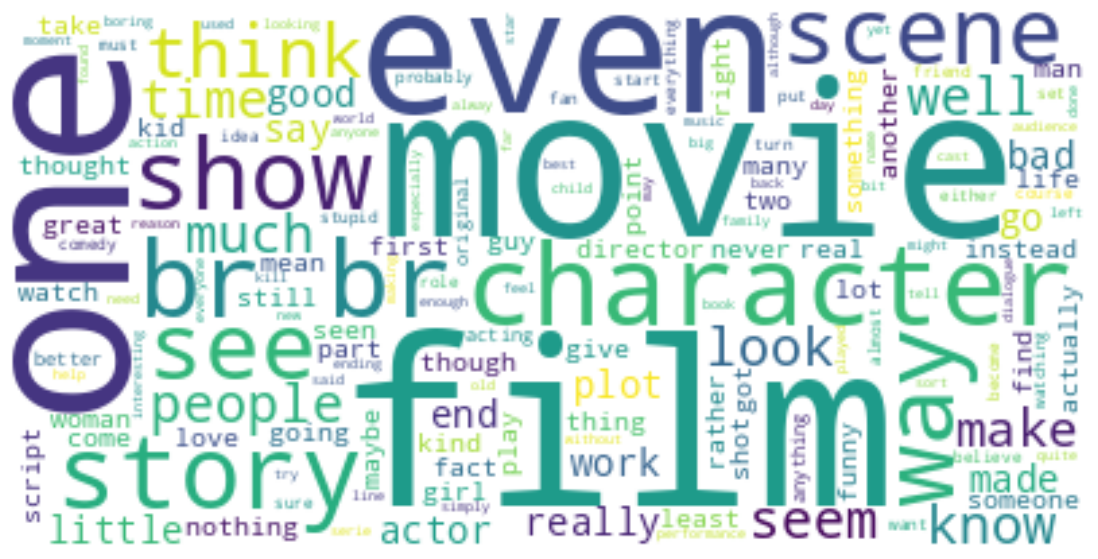

In [ ]:
neg = temp_df2.Text
neg_text = " ".join(review for review in neg.astype(str))

neg_wcloud=generate_wcloud(neg_text)

### Data visualisation

In [ ]:
pos_df = temp_df
neg_df = temp_df2

In [ ]:
pos_df.head()

,Text,Sentiment
0,barman directed way wind blow would sing deus ...,8
1,really liked tom barman awtwb let come enjoy l...,7
2,barman wanted make movie wanted simple succeed...,8
3,belgian film directed tom barman singer wellkn...,10
4,way wind blow tom barman also know front man r...,9


In [ ]:
neg_df.head()

,Text,Sentiment
0,movie worst movie ever made planet like barney...,1
1,first cgi movie horrible watched marathon bad ...,4
2,film sabretooth lose amusement park teen scave...,3
3,everything film hog wash pitiful acting awful ...,1
4,spoiler movie could better different script di...,2


Text(0.5, 1.0, 'Countplot of positive sentiments')

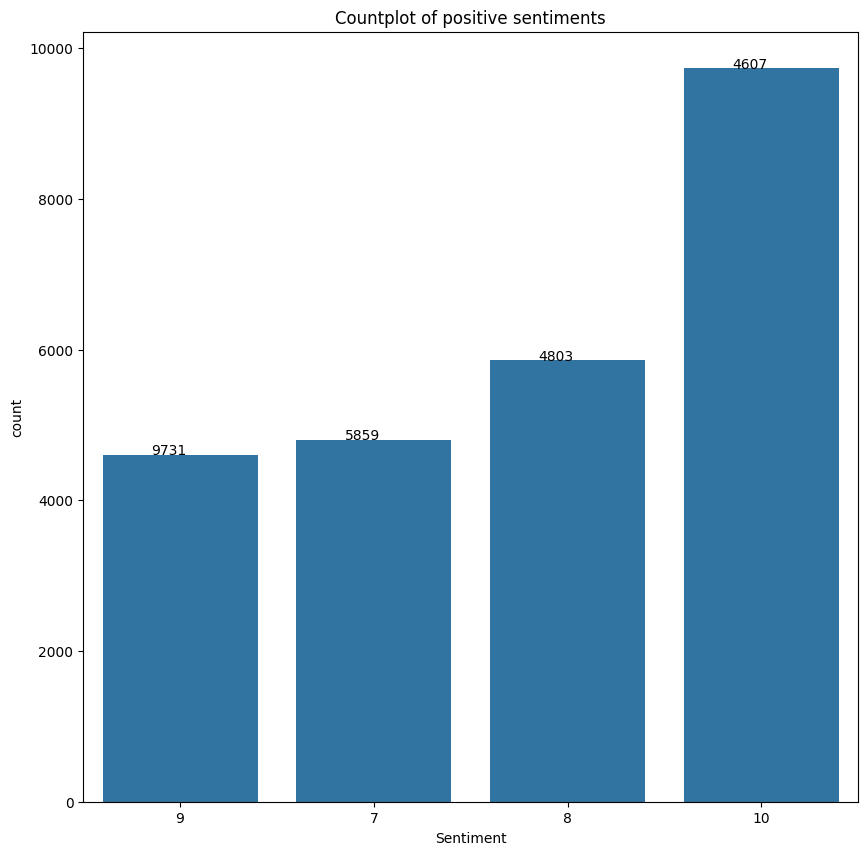

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.countplot(
    x="Sentiment",
    data=pos_df,
    order=pos_df['Sentiment'].value_counts(ascending=True).index
)

for p, label in zip(ax.patches, pos_df['Sentiment'].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5))

plt.title("Countplot of positive sentiments")

Text(0.5, 1.0, 'Countplot of negative sentiments')

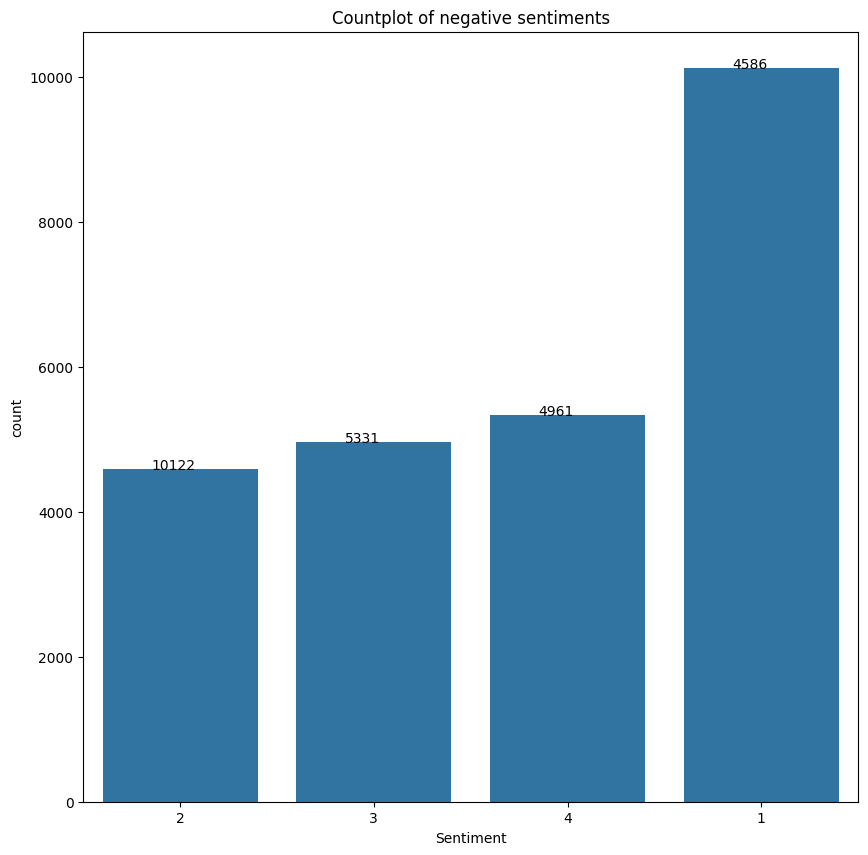

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.countplot(
    x="Sentiment",
    data=neg_df,
    order=neg_df['Sentiment'].value_counts(ascending=True).index
)

for p, label in zip(ax.patches, neg_df['Sentiment'].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5))

plt.title("Countplot of negative sentiments")

People are more likely to give extreme ratings (1 or 10)

Visuals for length of reviews (number of words)

In [ ]:
import re

# create new column that shows length of words for each dataframe
temp_pos_df = pos_df
temp_neg_df = neg_df

# function to get length of words
def length(text):
    return len(re.findall(r'\w+', text))

temp_pos_df['word_count'] = temp_pos_df['Text'].apply(length)
temp_neg_df['word_count'] = temp_neg_df['Text'].apply(length)

Text(0.5, 1.0, 'Histogram of length of reviews in positive sentiments')

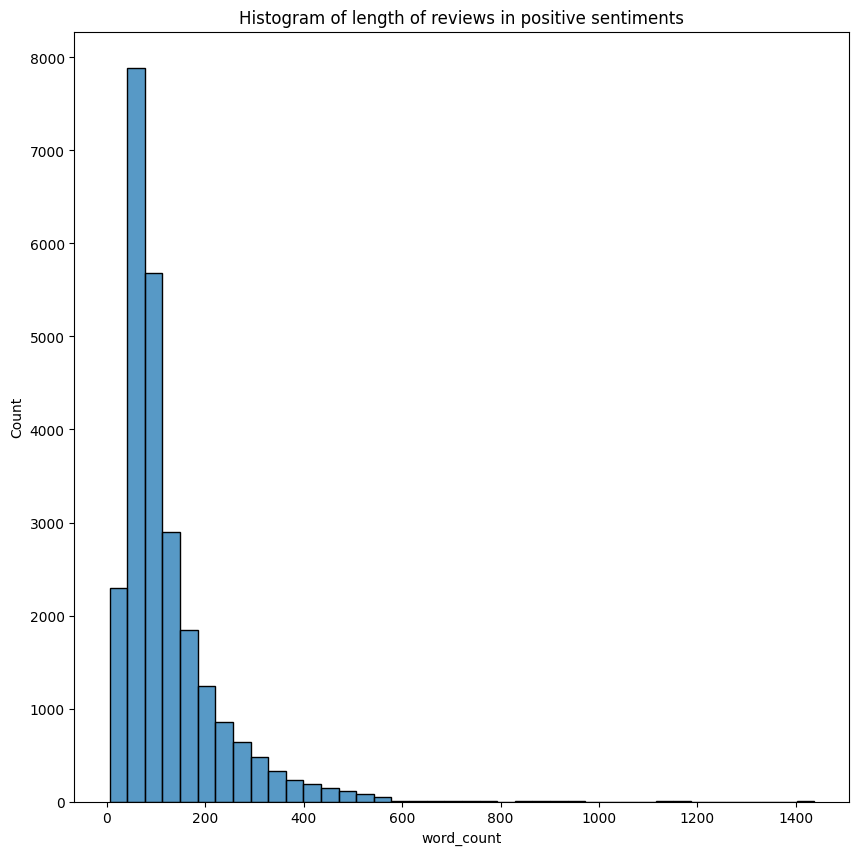

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.histplot(
    data=temp_pos_df,
    x='word_count',
    bins=40,
)

plt.title("Histogram of length of reviews in positive sentiments")

Text(0.5, 1.0, 'Histogram of length of reviews in negative sentiments')

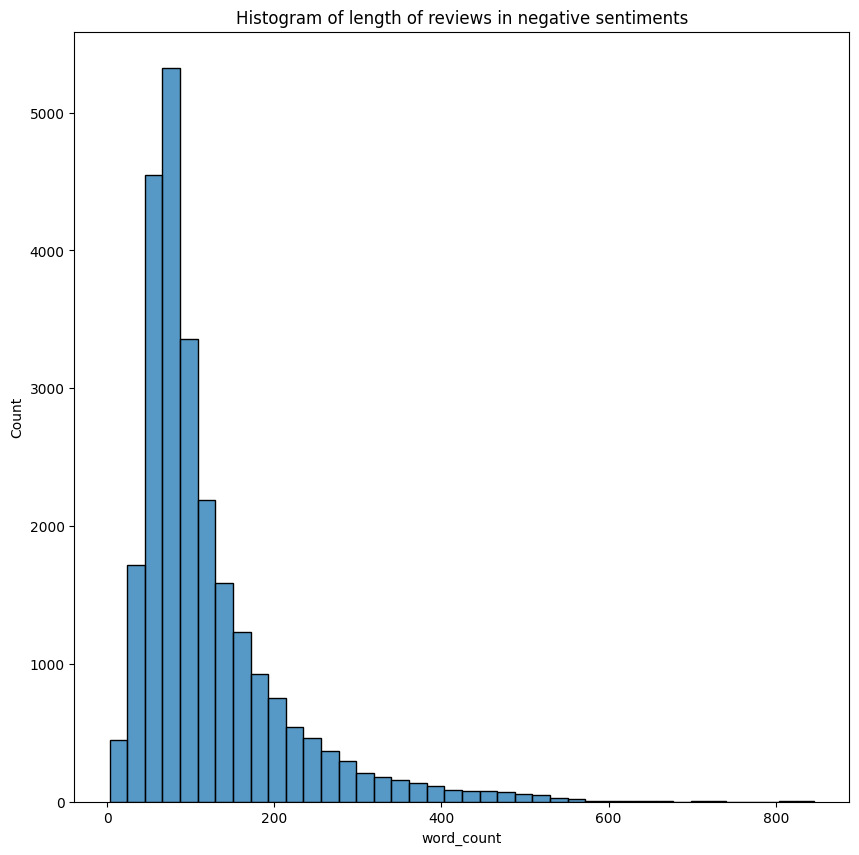

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.histplot(
    data=temp_neg_df,
    x='word_count',
    bins=40,
)

plt.title("Histogram of length of reviews in negative sentiments")

Both histograms are right-skewed

Most frequent number of words:
1. Roughly 66 for positive reviews
2. Roughly 80 for negative reviews

In [ ]:
temp_pos_df['positive?'] = 'positive'
temp_neg_df['positive?'] = 'negative'

temp_combined_df = pd.concat([temp_pos_df, temp_neg_df], ignore_index=True)
temp_combined_df.head()

,Text,Sentiment,word_count,positive?
0,barman directed way wind blow would sing deus ...,8,86,positive
1,really liked tom barman awtwb let come enjoy l...,7,66,positive
2,barman wanted make movie wanted simple succeed...,8,179,positive
3,belgian film directed tom barman singer wellkn...,10,88,positive
4,way wind blow tom barman also know front man r...,9,147,positive


Text(0.5, 1.0, 'Length of reviews in positive and negative sentiments')

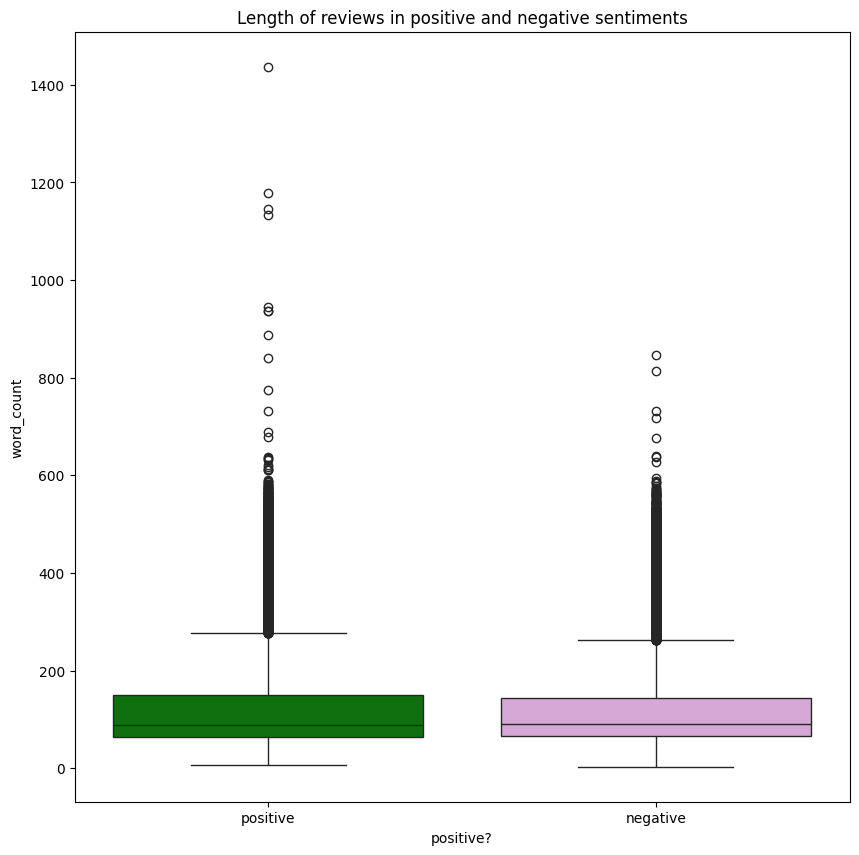

In [ ]:
plt.figure(figsize=(10,10))
palette = ['g', 'plum']

ax = sns.boxplot(
    data=temp_combined_df,
    y='word_count',
    x='positive?',
    palette=palette
)

plt.title("Length of reviews in positive and negative sentiments")

n-gram

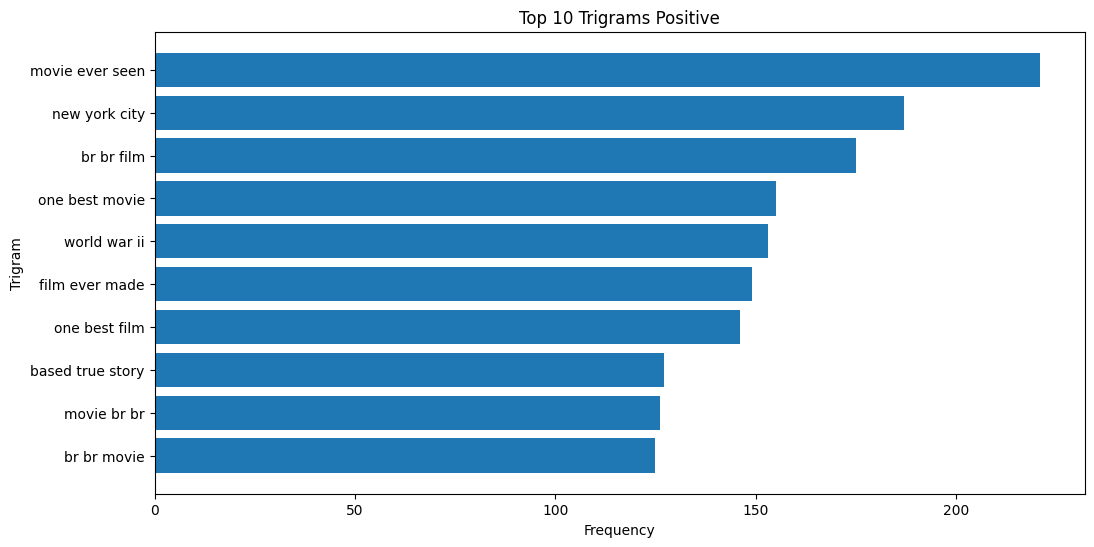

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Provided text
text = pos_text


# Create a CountVectorizer for trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3))
X = vectorizer.fit_transform([text])

# Get trigram vocabulary
trigram_vocab = vectorizer.get_feature_names_out()

# Get trigram counts
trigram_counts = X.toarray().flatten()

# Create a dictionary mapping trigrams to their counts
trigram_dict = dict(zip(trigram_vocab, trigram_counts))

# Get the top 10 trigrams
top_10_trigrams = sorted(trigram_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Extract trigram words and counts
trigram_words, trigram_counts = zip(*top_10_trigrams)

# Plot the top 10 trigrams
plt.figure(figsize=(12, 6))
plt.barh(trigram_words, trigram_counts)
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.title('Top 10 Trigrams Positive')
plt.gca().invert_yaxis()  # Reverse the order to show the most frequent trigrams at the top
plt.show()

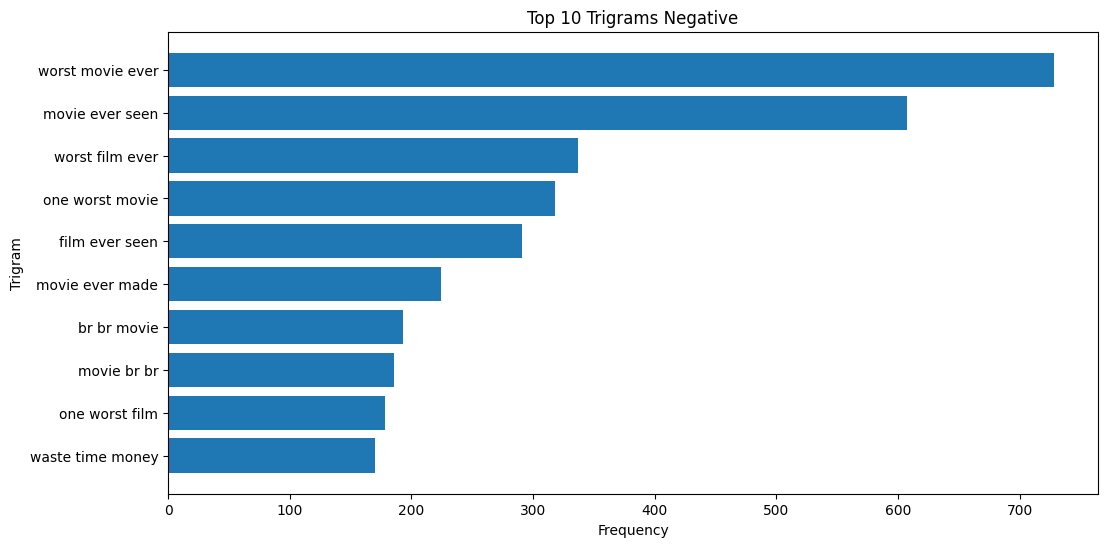

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Provided text
text = neg_text


# Create a CountVectorizer for trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3))
X = vectorizer.fit_transform([text])

# Get trigram vocabulary
trigram_vocab = vectorizer.get_feature_names_out()

# Get trigram counts
trigram_counts = X.toarray().flatten()

# Create a dictionary mapping trigrams to their counts
trigram_dict = dict(zip(trigram_vocab, trigram_counts))

# Get the top 10 trigrams
top_10_trigrams = sorted(trigram_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Extract trigram words and counts
trigram_words, trigram_counts = zip(*top_10_trigrams)

# Plot the top 10 trigrams
plt.figure(figsize=(12, 6))
plt.barh(trigram_words, trigram_counts)
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.title('Top 10 Trigrams Negative')
plt.gca().invert_yaxis()  # Reverse the order to show the most frequent trigrams at the top
plt.show()

Top bigram

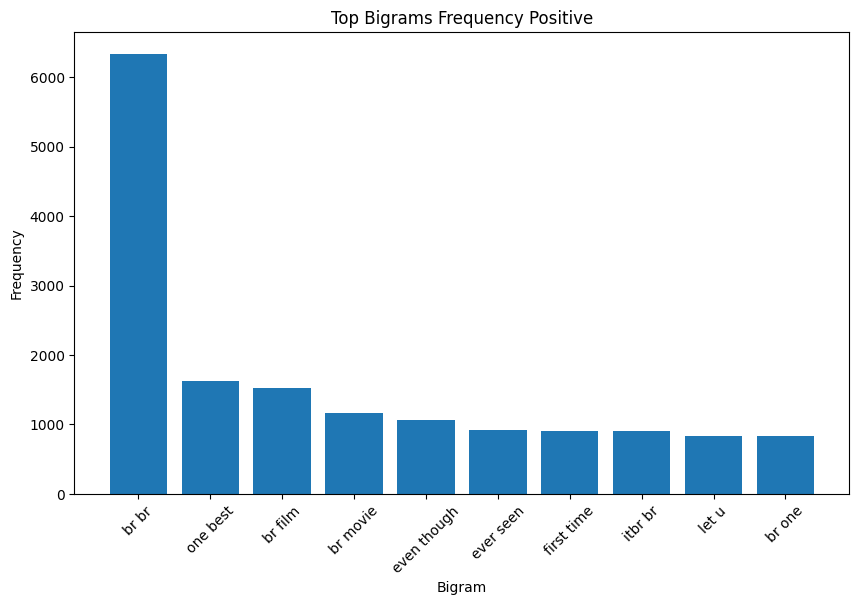

In [ ]:
import pandas as pd
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt


# Concatenate all text data into a single string
text = pos_text

# Tokenize the text
tokens = word_tokenize(pos_text.lower())

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

# Compute bigrams
bigrams = ngrams(tokens, 2)

# Count the frequency of each bigram
bigram_freq = Counter(bigrams)

# Get the top 10 bigrams
top_bigrams = bigram_freq.most_common(10)

# Plot the top bigrams
x, y = zip(*top_bigrams)
plt.figure(figsize=(10, 6))
plt.bar(range(len(x)), y, tick_label=[' '.join(item) for item in x])
plt.xticks(rotation=45)
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.title('Top Bigrams Frequency Positive')
plt.show()

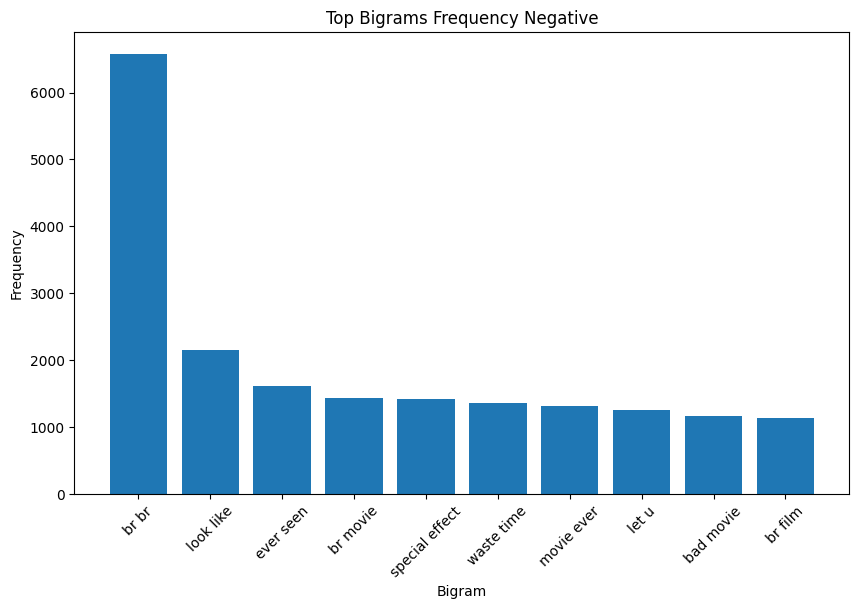

In [ ]:
import pandas as pd
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt


# Concatenate all text data into a single string
text = neg_text

# Tokenize the text
tokens = word_tokenize(neg_text.lower())

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

# Compute bigrams
bigrams = ngrams(tokens, 2)

# Count the frequency of each bigram
bigram_freq = Counter(bigrams)

# Get the top 10 bigrams
top_bigrams = bigram_freq.most_common(10)

# Plot the top bigrams
x, y = zip(*top_bigrams)
plt.figure(figsize=(10, 6))
plt.bar(range(len(x)), y, tick_label=[' '.join(item) for item in x])
plt.xticks(rotation=45)
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.title('Top Bigrams Frequency Negative')
plt.show()


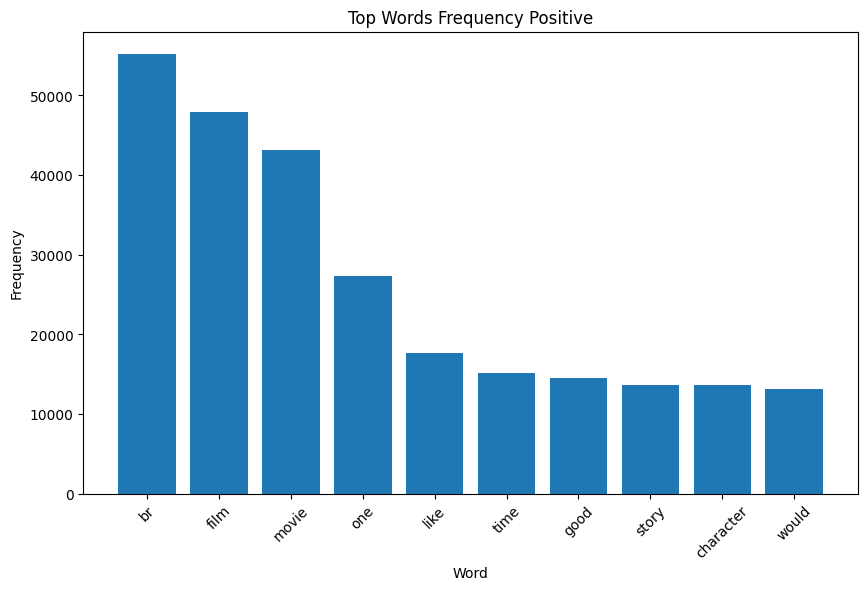

In [ ]:
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt


# Concatenate all text data into a single string
text = pos_text

# Tokenize the text
tokens = word_tokenize(pos_text.lower())

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

# Count the frequency of each word
word_freq = Counter(tokens)

# Get the top 10 most used words
top_words = word_freq.most_common(10)

# Plot the top words
x, y = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.bar(range(len(x)), y, tick_label=x)
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top Words Frequency Positive')
plt.show()

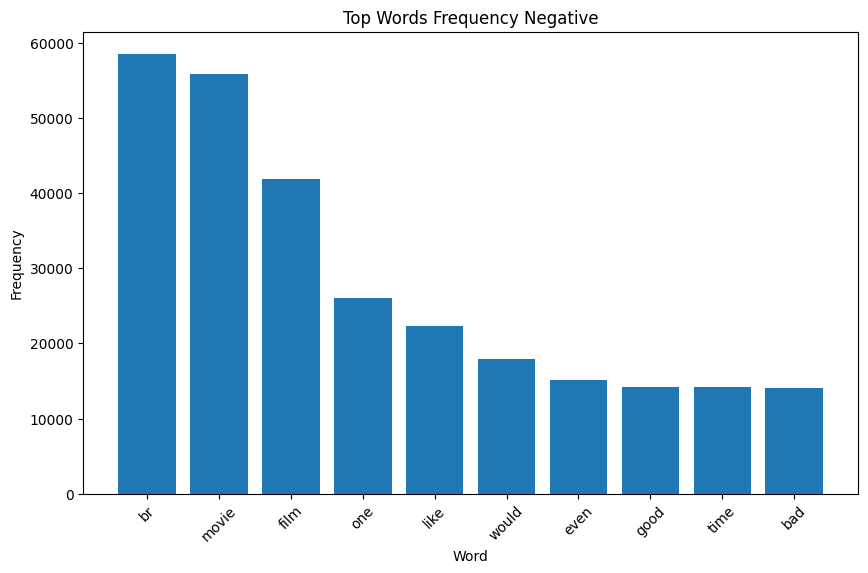

In [ ]:
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt


# Concatenate all text data into a single string
text = neg_text

# Tokenize the text
tokens = word_tokenize(neg_text.lower())

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

# Count the frequency of each word
word_freq = Counter(tokens)

# Get the top 10 most used words
top_words = word_freq.most_common(10)

# Plot the top words
x, y = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.bar(range(len(x)), y, tick_label=x)
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top Words Frequency Negative')
plt.show()